In [2]:
# !pip install networkx matplotlib numpy tqdm

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math
import random

# 1. Dolphins

In [3]:
# load data
!wget http://lovro.fri.uni-lj.si/ina/nets/dolphins.net



7[Files: 0  Bytes: 0  [0 B/s] Re]87[http://lovro.fri.uni-lj.si/ina]870 files              100% [=============================>]     162     --.-KB/s87[Files: 0  Bytes: 162  [895 B/s]870 files              100% [=============================>]     162     --.-KB/s87[https://lovro.fri.uni-lj.si/in]87dolphins.net         100% [=============================>]    1.69K    --.-KB/s87[Files: 1  Bytes: 1.85K [2.87KB]8

Text(0.5, 1.0, 'Betweenes-centrality of all Dolphins')

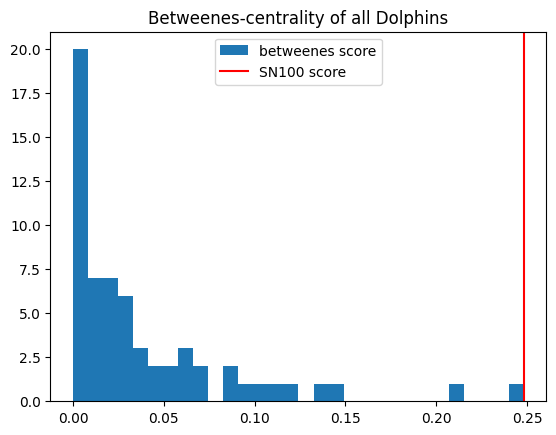

In [22]:
G_dolphins = nx.read_pajek("dolphins.net")
important_dolphin = "SN100"
results = nx.betweenness_centrality(G_dolphins)
important_score = results[important_dolphin]
results = [num for num in results.values()]

plt.hist(results, bins=30, label="betweenes score")
plt.axvline(important_score, label=f"{important_dolphin} score", color="red")
plt.legend()
plt.title("Betweenes-centrality of all Dolphins")

## answer

Betweenes centrality tells us how many shortest paths go through a specific node.  
I hipothesized that a node that will hold two group together will have the highest betweenes score and it turnd out it was correct

# 2. HIV and network sampling

In [23]:
!wget http://lovro.fri.uni-lj.si/ina/nets/social.net



7[Files: 0  Bytes: 0  [0 B/s] Re]87[http://lovro.fri.uni-lj.si/ina]870 files              100% [=============================>]     162     --.-KB/s87[Files: 0  Bytes: 162  [493 B/s]870 files              100% [=============================>]     162     --.-KB/s87[https://lovro.fri.uni-lj.si/in]87social.net             4% [>                             ]   15.33K    --.-KB/s87social.net            45% [============>                 ]  159.32K    1.12MB/s87social.net           100% [=============================>]  346.49K    1.47MB/s87[Files: 1  Bytes: 346.65K [316.]8

In [27]:
G_social = nx.read_pajek("social.net")

gen = nx.generate_random_paths(G_social, 50, 10) # Generates random walks

break_percent = round(len(G_social) * 0.15)
nodes = set()
for g in tqdm(gen):
  for n in g:
    nodes.add(n)
  if(len(nodes) > break_percent):
    break

G_induced = nx.induced_subgraph(G_social, list(nodes))

50it [00:04, 11.39it/s]


In [30]:
largest_cc = max(nx.connected_components(G_social), key=len)
print(f"Largest cc in ORIGINAL: {len(largest_cc)} being {len(largest_cc) / len(G_social)   * 100}% of the graph")
avg_cluster = nx.average_clustering(nx.Graph(G_social))
print(f"avg clustering: {avg_cluster}")

largest_cc = max(nx.connected_components(G_induced), key=len)
print(f"Largest cc in G_induced: {len(largest_cc)} being {len(largest_cc) / len(G_induced) * 100}% of the graph")
avg_cluster = nx.average_clustering(nx.Graph(G_induced))
print(f"avg clustering: {avg_cluster}")

Largest cc in ORIGINAL: 10680 being 100.0% of the graph
avg clustering: 0.2659452243010437
Largest cc in G_induced: 149 being 41.73669467787115% of the graph
avg clustering: 0.3496084190987538


/tmp/ipykernel_215394/4226467883.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


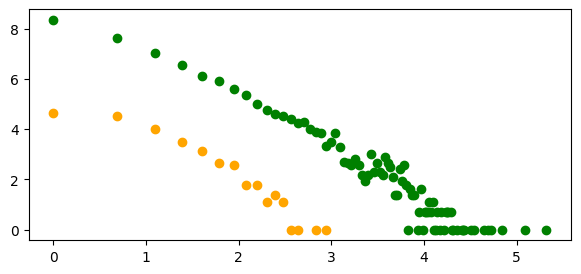

In [47]:
fig, ax = plt.subplots(1,1, figsize=(7,3))
degree_counts = np.bincount([d for n, d in G_social.degree()])
x = np.nonzero(degree_counts)[0]
y = degree_counts[x]
ax.scatter(np.log(x), np.log(y), color='green')

degree_counts = np.bincount([d for n, d in G_induced.degree()])
x = np.nonzero(degree_counts)[0]
y = degree_counts[x]
ax.scatter(np.log(x), np.log(y), color='orange')

fig.show()

The largest conected component is smaller than in the whole graph which makes sense to me.  
Social networks usually have one giant connected component and our random sampling could leave out some nodes that are necesssary for connecting smaller hubs together in one large one.

It does however, make sense that the average clustering is higher. We sample some nodes, but we take **all** of the edges between them, yieling a higher average edge count.

# 3. Ring graph modularity

![](./nal2_1.jpg)
![](./nal2.jpg)

# 4. Who's the winner

### i - Girvan-Newman benchmark graphs

In [175]:


import random


def generate_GN_graph(mu, num_nodes=3*24, num_clusters=3, exp_deg = 20):
  G = nx.MultiGraph(name="girvan-newman-graph")
  nodes_per_cluster = int(num_nodes / num_clusters)

  for i in range(num_nodes): # add 24 nodes for 3 groups
    G.add_node(i)

  for i in range(num_nodes*exp_deg):
      random_node = random.randint(0,num_nodes-1)
      cluster_id = random_node // nodes_per_cluster
      if(random.random() > mu):
        #  link within
        random_target = random.randint(cluster_id*nodes_per_cluster, (cluster_id + 1) * nodes_per_cluster) % num_nodes
      else:
        # link out
        random_target = random.randint((cluster_id + 1) * nodes_per_cluster, (cluster_id + num_clusters - 1) * nodes_per_cluster ) % num_nodes
      G.add_edge(random_node, random_target)
  return G  

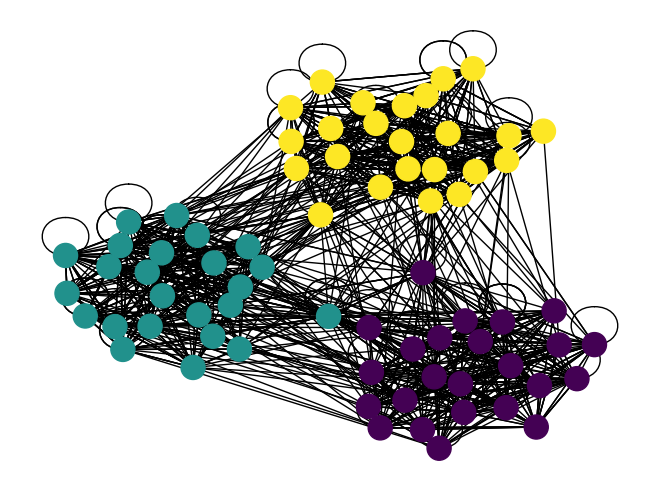

In [177]:
n_nodes = 3*24
G = generate_GN_graph(0.1, n_nodes, 3, 20)
nx.draw(G, node_color=[i // 24 for i in range(n_nodes)])

For each algorithm and each value of µ, compute
normalized mutual information between the planted partition and detected community
structure, and average the results.

In [178]:
# !pip install igraph
# !pip install scikit-learn
import igraph as igr
from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score

In [179]:
def louvain(G):
    predicted = [None] * len(G)
    for label, cluster in enumerate(nx.community.louvain_communities(G)):
        for node in cluster:
            predicted[int(node)] = label
    return predicted

def flp(G):
    predicted = [None] * len(G)
    for label, cluster in enumerate(nx.community.fast_label_propagation_communities(G)):
        for node in cluster:
            predicted[int(node)] = label
    return predicted

def infomap(G):
    return igr.Graph.from_networkx(G).community_infomap().membership

In [183]:
mus =[0, 0.1, 0.2, 0.3, 0.4, 0.5]
n_repetitions = 25
algos = [louvain, flp, infomap]
comunities = [[] for i in range(len(algos))] # dim0 = algos, dim1 = mu, dim2 = repetition 

for mu in tqdm(mus):
  for com in comunities:
    # append one array fo each mu:
    com.append([])
  for repetition in range(n_repetitions):
    G = generate_GN_graph(mu, n_nodes, 3, 20)
    true_partitions = [int(n // int((n_nodes/3))) for n in G.nodes()]
    for algo_n in range(len(algos)):
      comunity = algos[algo_n](G)
      comunities[algo_n][-1].append(normalized_mutual_info_score(true_partitions, comunity))

100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


Plot community detection accuracy of the algorithms
on a single plot with µ on the horizontal axis and normalized mutual information (NMI)
on the vertical axis.

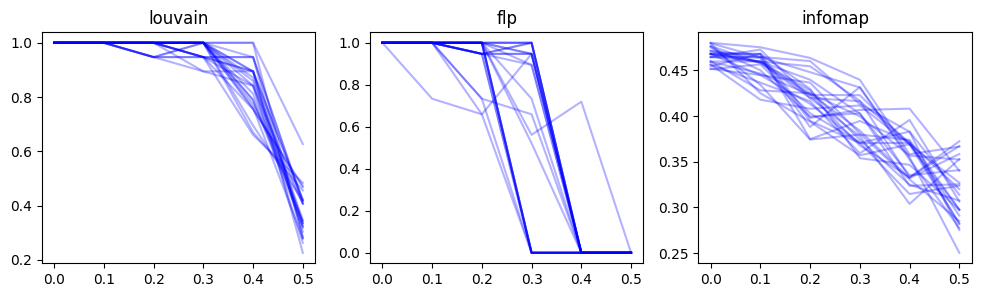

In [184]:
fig, ax = plt.subplots(1,len(algos), figsize=(12,3))
for func_i in range(len(algos)):
    algo = algos[func_i]
    name = algo.__name__
    ax[func_i].set_title(name)
    for rep_i in range(n_repetitions):
        ax[func_i].plot(mus,np.array(comunities[func_i])[:,rep_i], alpha=0.3, c="blue")

- Louvain gives the best scores a shown by the graph
- FLP pefroms well untill a cuttoff point at 0.2, after which it becomes unstable
- Infomap has a predictable curve over the serie of mu-s but duesnt perform as well as Louvain

##  Lancichinetti benchmark graphs

In [187]:
# !wget http://lovro.fri.uni-lj.si/ina/nets/LFR.zip && unzip LFR.zip && rm LFR.zip
import os

In [216]:
# generate graph and true data from pajek
DATA_PATH = "./LFR"
def get_graph(mu, i):
  path = os.path.join(DATA_PATH, f"LFR_{mu:02}_{i}.net")
  G = nx.MultiGraph(name="Lancichinetti")
  gt = []
  with open(path) as f:
    f.readline()
    for l in f:
      if "*" in l: break

      node,_, group = l.split(" ")
      node, group = int(node), int(group)
      gt.append(group)
      G.add_node(node-1)

    for l in f:
      fr, to = l.split(" ")
      fr, to = int(fr), int(to)
      G.add_edge(fr-1,to-1)
  
  return G, gt


G, gt = get_graph(2, 15)
print(len(G), len(gt))

2500 2500


In [217]:
mus =[0,2,4,6,8]
n_repetitions = 25
algos = [louvain, flp, infomap]
comunities = [[] for i in range(len(algos))] # dim0 = algos, dim1 = mu, dim2 = repetition 

for mu in tqdm(mus):
  for com in comunities:
    # append one array fo each mu:
    com.append([])
  for repetition in range(n_repetitions):
    G, true_partitions  = get_graph(mu, repetition)
    for algo_n in range(len(algos)):
      comunity = algos[algo_n](G)
      comunities[algo_n][-1].append(normalized_mutual_info_score(true_partitions, comunity))

100%|██████████| 5/5 [04:16<00:00, 51.32s/it]


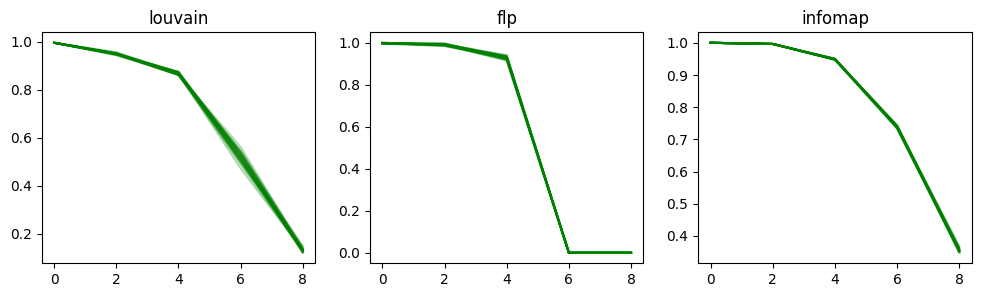

In [218]:
fig, ax = plt.subplots(1,len(algos), figsize=(12,3))
for func_i in range(len(algos)):
    algo = algos[func_i]
    name = algo.__name__
    ax[func_i].set_title(name)
    for rep_i in range(n_repetitions):
        ax[func_i].plot(mus,np.array(comunities[func_i])[:,rep_i], alpha=0.3, c="green")

Resoults here look much cleaner and less random. Even infomap now shows a clar curve.  

- Louain has good performance and drops off slowly
- FLP has a good performance untill the $mu=0.4$ cutoffpoint
- Infomap has best results when mu gets higher. It outperforms other algorithms for $mu \lt 0.4$

### Erdos-reny

In [219]:
mus =[8, 16, 24, 32, 40]
n_repetitions = 25
algos = [louvain, flp, infomap]
comunities = [[] for i in range(len(algos))] # dim0 = algos, dim1 = mu, dim2 = repetition 

for mu in tqdm(mus):
  for com in comunities:
    # append one array fo each mu:
    com.append([])
  for repetition in range(n_repetitions):
    G = nx.erdos_renyi_graph(1000, mu / (1000 - 1))
    true_partitions = [n for i in G.nodes()]
    for algo_n in range(len(algos)):
      comunity = algos[algo_n](G)
      comunities[algo_n][-1].append(normalized_mutual_info_score(true_partitions, comunity))

100%|██████████| 5/5 [02:13<00:00, 26.66s/it]


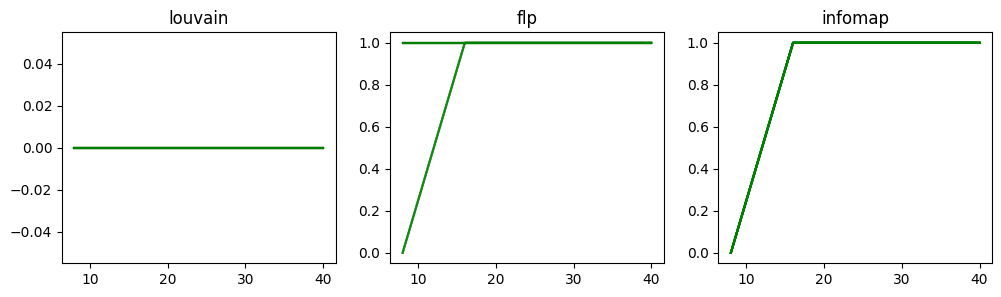

In [220]:
fig, ax = plt.subplots(1,len(algos), figsize=(12,3))
for func_i in range(len(algos)):
    algo = algos[func_i]
    name = algo.__name__
    ax[func_i].set_title(name)
    for rep_i in range(n_repetitions):
        ax[func_i].plot(mus,np.array(comunities[func_i])[:,rep_i], alpha=0.3, c="green")

We can see, that only **Louvain** has successfully detected that there are no grouping so to be found in the random graph

# Get at least 70% right!

In [237]:
from networkx.algorithms import node_classification

In [234]:
# generate graph and true data from pajek
def get_graph_social():
  path = "./aps_2008_2013.net"
  G = nx.MultiGraph(name="aps_net")
  with open(path) as f:
    f.readline()
    for l in f:
      if "*" in l: break

      node,data, _ = l.split(" ")
      data = data.replace("\"","")
      year = int(data.split("-")[-1])
      journal = data.split("/")[-1].split(".")[0]
      G.add_node(int(node), year=year, journal=journal)

    for l in f:
      fr, to = l.split(" ")
      fr, to = int(fr), int(to)
      G.add_edge(fr-1,to-1)
  
  return G

In [235]:
# !wget http://lovro.fri.uni-lj.si/ina/nets/aps_2008_2013.net
G = get_graph_social()

In [239]:
print(G.nodes(data=True)[1])

{'year': 2008, 'journal': 'PhysRevA'}


In [246]:
new_nodes = []
for node, data in G.nodes(data=True):
  if "year" not in data.keys(): continue
  if data["year"] == 2013:
    new_nodes.append(node)

I'll try using the inbult nod classification given in networkx

In [251]:
accuracy = []
for tr in range(10): # try multiple iterations
    classifications = node_classification.local_and_global_consistency(nx.MultiGraph(G), label_name='journal')
    results = 0
    for paper in new_nodes:
        if G.nodes(data=True)[paper]['journal'] == classifications[paper]:
            results += 1
    accuracy.append(results / len(new_nodes))
print(np.mean(accuracy))

0.7764256132526282


As the results are abve 0.7, we need no further refining.  

# Peers, ties and the Internet

In [3]:
!wget http://lovro.fri.uni-lj.si/ina/nets/gnutella.net
!wget http://lovro.fri.uni-lj.si/ina/nets/circles.net
!wget http://lovro.fri.uni-lj.si/ina/nets/nec.net

--2024-05-03 15:57:51--  http://lovro.fri.uni-lj.si/ina/nets/gnutella.net
Resolving lovro.fri.uni-lj.si (lovro.fri.uni-lj.si)... 2606:50c0:8000::153, 2606:50c0:8001::153, 2606:50c0:8002::153, ...
Connecting to lovro.fri.uni-lj.si (lovro.fri.uni-lj.si)|2606:50c0:8000::153|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://lovro.fri.uni-lj.si/ina/nets/gnutella.net [following]
--2024-05-03 15:57:51--  https://lovro.fri.uni-lj.si/ina/nets/gnutella.net
Connecting to lovro.fri.uni-lj.si (lovro.fri.uni-lj.si)|2606:50c0:8000::153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2554388 (2.4M) [application/octet-stream]
Saving to: ‘gnutella.net’

gnutella.net        100%[===================>]   2.44M  7.15MB/s    in 0.3s    

2024-05-03 15:57:52 (7.15 MB/s) - ‘gnutella.net’ saved [2554388/2554388]

--2024-05-03 15:57:52--  http://lovro.fri.uni-lj.si/ina/nets/circles.net
Resolving lovro.fri.uni-lj.si (lovro.fri.uni-lj.si)...

## X

### question

Assume that you apply a link prediction method to all unlinked pairs of nodes of a large real
network and later evaluate between which pairs of nodes the links occurred. Considering
the density of real networks, what would be the expected classification accuracy of a
method that simply predicts that no links will occur

### answer

Asssume we look at a large netowrk like Facebook.  

If we consider a large real network, it's likely to exhibit a high level of density, meaning that a significant portion of possible links between nodes are already present. In such networks, the number of existing links typically outweighs the number of possible unlinked pairs.

If a link prediction method simply predicts that no links will occur between any unlinked pairs of nodes, it would essentially be guessing that all potential links are absent. In a dense network, this guess would often be correct, resulting in a high accuracy.

## Y

In [4]:
def sample_two_unconnected_nodes(graph):

  # Attempt to find two unconnected nodes
  while True:
    # Select two random nodes
    node1 = random.choice(list(graph.nodes))
    node2 = random.choice(list(graph.nodes))
    
    # Check if the nodes are not connected
    if not graph.has_edge(node1, node2):
      return node1, node2

def sample_random_edges(graph, n):
  
  # Get all edges in the graph
  all_edges = list(graph.edges)
  
  # Shuffle the list of edges to ensure randomness
  random.shuffle(all_edges)
  
  # Return the first 'n' edges
  return all_edges[:n]

In [19]:
def scale_free_index(node1, node2, G:nx.MultiGraph):
  return  G.degree(node1) * G.degree(node2)

def node_neighbour_similarity(n1, n2, G):
    # Find the common neighbors of n1 and n2
    common_neighbors = set(G.neighbors(n1)) & set(G.neighbors(n2))
    
    # Initialize the sum of logarithms
    sum_log_degrees = 0
    
    # Iterate over each common neighbor
    for neighbor in common_neighbors:
        # Calculate the logarithm of the degree of the neighbor
        log_degree = np.log(G.degree(neighbor))
        
        # Add the logarithm to the sum
        sum_log_degrees += log_degree
    
    # Return the sum of logarithms as the Adamic-Adar index
    return sum_log_degrees


In [16]:
def perf_framework(G:nx.MultiGraph, s):
  # print("init")
  G = G.copy()
  m = len(G.edges())

  # print("sample negaitve")
  Ln = []
  while len(Ln) < m/100:
    node1 ,node2 = sample_two_unconnected_nodes(G)
    Ln.append((node1,node2))

  # print("sample positive")
  Lp = []
  edges = sample_random_edges(G, m//10)
  for e in edges:
    Lp.append(e)
    G.remove_edge(e[0],  e[1])

  # AUC
  Ln_resampled = []
  Lp_resampled = []
  # print("resample")
  for i in range(m//10):
    pair_n_i = np.random.randint(0, len(Ln)-1)
    p = Ln[pair_n_i]
    sn = s(p[0], p[1], G)
    Ln_resampled.append(sn)
    pair_p_i = np.random.randint(0, len(Lp)-1)
    p = Lp[pair_p_i]
    sn = s(p[0], p[1], G)
    Lp_resampled.append(sn)

  Ln_resampled = np.array(Ln_resampled)
  Lp_resampled = np.array(Lp_resampled)
  
  m_ = np.sum(Ln_resampled < Lp_resampled)
  m__ = np.sum(Ln_resampled == Lp_resampled)
  return (m_ + (m__/2))/(m/10)



In [7]:
gnutella = nx.read_pajek("./gnutella.net")
fb = nx.read_pajek("./circles.net")
nec = nx.read_pajek("./nec.net")


In [13]:
es = nx.erdos_renyi_graph(25000, 0.01)

## Z

In [20]:
algos = [scale_free_index, node_neighbour_similarity ]
graphs = [gnutella, fb, nec, es]

out = [[] for i in range(len(algos))]

for i, algo in enumerate(algos):
  for graph in graphs:
    for _ in tqdm(range(10)):
        auc = perf_framework(graph, algo)
        out[i].append(auc)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:18<00:00, 18.80s/it]


In [21]:

print(out)

[[0.7224528710139831, 0.8324455425346239, 0.8208957312414468], [0.5040164444324237, 0.9876578189813451, 0.5850127477841804]]


<BarContainer object of 2 artists>

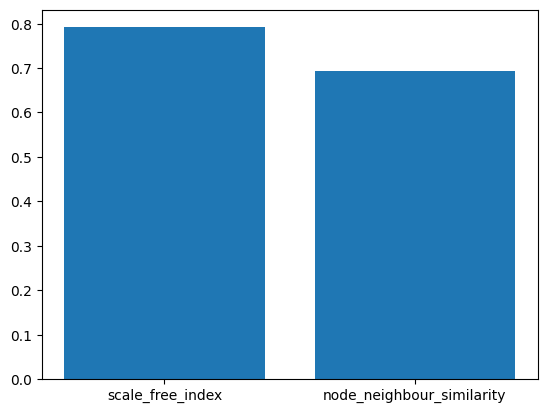

In [23]:
out = np.array(out)
mean = np.mean(out, axis=1)
names = [a.__name__ for a in algos]
plt.bar(names, mean)

We can see that scale free index performed better then node_neighbour_simmilarity by a small margin.

Due to long running time i coul only sample the nodes 10 times and this may cause hig variance in our outputs